In [57]:
# imports

from datasets import load_dataset, Dataset, DatasetDict
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import string
import os
import re

In [58]:
# Creating a directory to save data as csv

current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, '..'))
data_dir = os.path.abspath(os.path.join(main_dir, 'data'))
os.makedirs(data_dir, exist_ok=True)

In [59]:
# Load dataset
df = pd.read_csv('/Users/erum/LHL_LLM/data/Customer_Reviews.csv')

In [60]:
# Inspect
print(df.head())

   Unnamed: 0                                          book name  \
0          17  Friends, Lovers, and the Big Terrible Thing: A...   
1         131                      Lessons in Chemistry: A Novel   
2         464                           Flash Cards: Sight Words   
3         644  A Court of Mist and Fury (A Court of Thorns an...   
4          78  The Ballad of Songbirds and Snakes (A Hunger G...   

                                        review title          reviewer  \
0                                    A very sad read  Veronica R Ewing   
1                    I LOVE THIS BOOK!! 😍 ⭐️⭐️⭐️⭐️⭐️             Sonia   
2                     Amazing for struggling readers     Ryan Williams   
3  The ending was stunning, as always, but I had ...          Brittany   
4                                         So Good!!!   Kindle Customer   

   reviewer rating                                 review description  \
0                4  What a shock to lose such a talented and funny...   


In [61]:
# Count unique values in the 'review title' column
unique_count = df['review title'].nunique()
print(f"Number of unique review titles: {unique_count}")

Number of unique review titles: 819


In [62]:
top_titles = df['review title'].value_counts().head(10)
print(top_titles)


review title
Great book        14
Cute book         10
Book               6
Cute               5
Love it            4
Great              4
Great book!        4
Love               3
A must read        3
Love this book     3
Name: count, dtype: int64


In [63]:
top_title_list = top_titles.index.tolist()
df['title_group'] = df['review title'].apply(lambda x: x if x in top_title_list else 'Other')


In [64]:
# Combine review title and description
df['text'] = df['review title'].fillna('') + '. ' + df['review description'].fillna('')

# Clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    return text.lower().strip()

df['clean_text'] = df['text'].apply(clean_text)


In [65]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download('stopwords')

# Define stopword set
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

# Apply to cleaned text
df['clean_text_nostop'] = df['clean_text'].apply(remove_stopwords)

# Rename the column
df = df.rename(columns={'clean_text_nostop': 'sentiment'})



[nltk_data] Downloading package stopwords to /Users/erum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
# Keep only the last occurrence of 'sentiment'
df = df.loc[:, ~df.columns.duplicated(keep='last')]


In [67]:
# prompt: show headers

df.columns

Index(['Unnamed: 0', 'book name', 'review title', 'reviewer',
       'reviewer rating', 'review description', 'is_verified', 'date',
       'timestamp', 'ASIN', 'Author', 'title_group', 'text', 'clean_text',
       'sentiment'],
      dtype='object')

In [68]:
df[['sentiment', 'reviewer rating']].dropna().to_csv('cleaned_reviews.csv', index=False)


In [69]:
# Define labeling function
def classify_sentiment(text):
    text = text.lower()
    if any(word in text for word in ['excellent', 'great', 'love', 'amazing', 'perfect', 'recommend', 'good']):
        return 'recommended'
    elif any(word in text for word in ['bad', 'poor', 'terrible', 'worst', 'disappointed', 'not recommend']):
        return 'not recommended'
    else:
        return 'neutral'

# Apply function to sentiment column
df['label'] = df['sentiment'].apply(classify_sentiment)


In [70]:
# prompt: Using dataframe df: convert in csv

df.to_csv("df.csv")

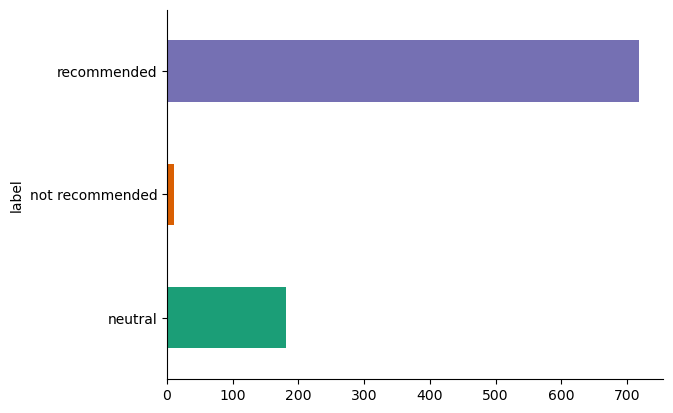

In [71]:
 #title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Dataset has many more examples of recommended than others. Class imbalance problem.

/var/folders/vh/hr9w_0vd1xv4xfslxfhrwmxh0000gn/T/ipykernel_23163/3740740557.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='reviewer rating', y='label', inner='box', palette='Dark2')


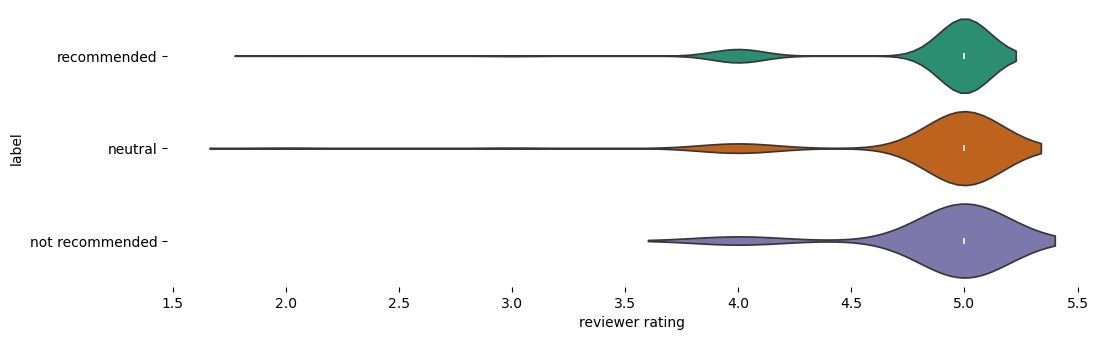

In [72]:
# @title label vs reviewer rating

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['label'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='reviewer rating', y='label', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

reviewer ratings (e.g., stars or numeric scores) does'nt  seem to align with the sentiment expressed in the review text.

In [73]:
# Split dataset into three separate Dataframes
# 0 → recommended
# 1 → not recommended
# 2 → neutral
recommended = df[df['label'] == 'recommended']
not_recommended = df[df['label'] == 'not recommended']
neutral = df[df['label'] == 'neutral']

In [74]:
print("Class distribution:")
print(df['label'].value_counts())


Class distribution:
label
recommended        719
neutral            181
not recommended     10
Name: count, dtype: int64


In [75]:
# Balancing Classes via Upsampling
from sklearn.utils import resample

# Find the majority class size
max_size = max(len(recommended), len(not_recommended), len(neutral))

# Upsample each class to match the majority size
recommended_upsampled = resample(recommended, replace=True, n_samples=max_size, random_state=42)
not_recommended_upsampled = resample(not_recommended, replace=True, n_samples=max_size, random_state=42)
neutral_upsampled = resample(neutral, replace=True, n_samples=max_size, random_state=42)

# Combine into a balanced dataset
df_balanced = pd.concat([recommended_upsampled, not_recommended_upsampled, neutral_upsampled])


In [76]:
# Shuffling the Balanced Dataset
from sklearn.utils import shuffle
df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)


In [77]:
# Mapping labels on the balanced dataset
label_map = {
    'recommended': 0,
    'Not recommended': 1,
    'neutral': 2
}

df_balanced['label_id'] = df_balanced['label'].map(label_map)


In [78]:
print(df_balanced['label'].value_counts())


label
not recommended    719
neutral            719
recommended        719
Name: count, dtype: int64


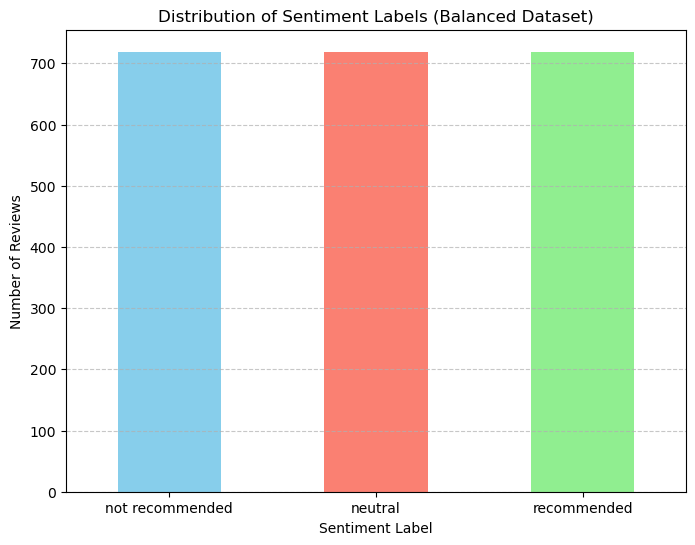

In [79]:
# bar chart

sentiment_counts = df_balanced['label'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribution of Sentiment Labels (Balanced Dataset)')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [80]:
# Inspect Data set 
df_balanced.head()


,Unnamed: 0,book name,review title,reviewer,reviewer rating,review description,is_verified,date,timestamp,ASIN,Author,title_group,text,clean_text,sentiment,label,label_id
0,832,Rich Dad Poor Dad: What the Rich Teach Their K...,This book changed my life,sherritha,5,groundbreaking book that explores the stark co...,True,20-10-2023,"Reviewed in the United States October 20, 2023",1612681131,Robert Kiyosaki,Other,This book changed my life. groundbreaking book...,this book changed my life groundbreaking book ...,book changed life groundbreaking book explores...,not recommended,NaN
1,764,Paint by Sticker Kids: Christmas: Create 10 Pi...,takes lots of time,Julie,4,"This is a fun activity. However, for small 5 y...",True,26-04-2023,"Reviewed in the United States April 26, 2023",152350675X,Workman Publishing,Other,takes lots of time. This is a fun activity. Ho...,takes lots of time this is a fun activity howe...,takes lots time fun activity however small yr ...,neutral,2.0
2,205,A Little Life,Heartbreaking but beautiful,Amazon Customer,5,I rarely come across a book that lingers with ...,True,02-10-2023,"Reviewed in the United States October 2, 2023",804172706,Hanya Yanagihara,Other,Heartbreaking but beautiful. I rarely come acr...,heartbreaking but beautiful i rarely come acro...,heartbreaking beautiful rarely come across boo...,neutral,2.0
3,363,Hundred Years' War on Palestine,Must read in these times,Tina,5,This book is required reading to get the real ...,True,04-11-2023,"Reviewed in the United States November 4, 2023",1250787653,Rashid Khalidi,Other,Must read in these times. This book is require...,must read in these times this book is required...,must read times book required reading get real...,neutral,2.0
4,193,A Court of Thorns and Roses (A Court of Thorns...,Beautiful Cover,Ohlookabunny,4,"Having heard much raving about this series, I ...",True,19-07-2023,"Reviewed in the United States July 19, 2023",1635575567,Sarah J. Maas,Other,Beautiful Cover. Having heard much raving abou...,beautiful cover having heard much raving about...,beautiful cover heard much raving series pokin...,recommended,0.0


In [81]:
# balanced dataset to a CSV file
df_balanced.to_csv('df_balanced.csv', index=False)
